In [1]:
#All the imports we will need
import math
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from matplotlib import pyplot as plt
import gc
import time
import tracemalloc

#Custom files
from logP import *
from get_pyrosetta_scores import get_pyrosetta_scores_from_sequence
from bmDCA import *

/home/joseph/summer2020_personal/Bayesian_Optimization/utils.py:2: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.loops.loop_closure.kinematic_closure import *


PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
[Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', 

In [2]:
#Mock experimental functionality score, currently higher is better                                                                                   
def hammingDist(str1, str2): 
    count = 0 
    for i in range(len(str1)):
        if(str2[i] != str1[i]):
            count+=1
    return count/len(str1)



In [3]:
"""

scalarization of objectives (y) sum of coefficients equals one will minimize "cost" 
calculate scalarized cost for a single y value 

"""
#objects below to assist in consistent scoring and sequence finding
vae = VAE_Operator()
dca = DCA_scorer()

def standardize_multi_dimensional_cost(y_):
    """
        standardizes scores to mean 0, and range -1 to 1
        
        inputs: multi dim score list
        returns: standardize score list
    
    """
    y_standardized = np.array(y_)
    for i in range(len(y_standardized[0])):
        mean = np.mean(y_standardized[:,i])
        std = np.std(y_standardized[:,i])
        y_standardized[:,i] = (y_standardized[:,i]-mean)/std
    return y_standardized
        

def multi_dimensional_cost(x):
    """
        scores point x on four metrics (vae, pyr, dca, functionality)
        ~Important: BO set up to minimize~
        
        inputs: point x (vae latent encoding)
        returns: list of scores [vae, pyr cost, dca, functionality] and new sequence tested
    """
    sequence = vae.get_seq_from_z(x)
    vae_prob = vae.get_score_from_z(x)[0] 
    pyr_score = get_pyrosetta_scores_from_sequence(sequence)
    dca_prob = dca.get_dca_scores_from_seq(sequence)[0] 
    functionality_prob = hammingDist("A"*62, sequence)
    return ([vae_prob*(-1), pyr_score, dca_prob*(-1), functionality_prob*(-1)], sequence)

def scalarized_cost(y_singular,lambda_,rho=0.05):
    """
        scalarizes a single multidimensional (4) score list by some normalized lambda_
        
        inputs: y_singular=a 4 length score array, lambda_=a normalized random vector for bayesian optimization, rho=hyperparameter for tuning
        returns: a single scaralized score
    """
    lambda_ /= np.sum(lambda_)
    p = np.multiply(y_singular, lambda_)
    return np.max(p) + np.sum(p * rho)

def calc_scal_from_observations(y):
    """
        calc scalarized cost for entire run based on scalarized lambda
        
        inputs: np.array of all y scores {(nx4) generally}
        returns: a 1d np.array of scaralized scores for 
    """
    lambda_ = np.random.random(len(y[0]))
    lambda_ /= np.sum(lambda_)
    scalar_scores = np.zeros(len(y))
    y_standardized = standardize_multi_dimensional_cost(y)
    for counter, y_singular in enumerate(y_standardized):
        cost = scalarized_cost(y_singular, lambda_)
        scalar_scores[counter] = cost
    return (scalar_scores, lambda_)

#expected improvement (to be maximized across whole x_space)
def EI(muNew, stdNew, fMax, epsilon=0.01):
    """
    Expected improvement acquisition function
    INPUT:
    - muNew: mean of predicted point in grid
    - stdNew: sigma (square root of variance) of predicted point in grid
    - fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
    - epsilon: trade-off parameter (>=0)
    [Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])
    OUTPUT:
    - EI: expected improvement for candidate point
    As describend in:
    E Brochu, VM Cora, & N de Freitas (2010):
    A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
    arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
    """

    Z = (muNew - fMax - epsilon) / stdNew

    return (muNew - fMax - epsilon) * scipy.stats.norm.cdf(
        Z
    ) + stdNew * scipy.stats.norm.pdf(Z) * (-1)



# BO Minimizes # 


The current build searches for a scalarized **minimum**. This means that VAE, DCA, and Functionality probabilites are multiplied by negative one when scored and reported to the algorithm.

In [82]:
class BO():
    def __init__(self, initial_x, initial_y):
        self.model = GaussianProcessRegressor()
        self.observed_x = initial_x
        self.observed_y = initial_y
        self.observed_y_scalarized, _ = calc_scal_from_observations(self.observed_y)
        self.model.fit(self.observed_x, self.observed_y_scalarized)
        self.average_scores = np.zeros(1)
        self.sequences = []

        
    def propose_new(self, resolution=1000000, dim=3):
        best = np.max(self.observed_y_scalarized)
        
        #with sigma^2 equal to 0.75^2, generate a bunch of random sequences to maximize acq
        x_space = 0.75*np.random.randn(resolution,dim)
        
        mu, std = self.model.predict(x_space, return_std = True)
        #evaluate ei at a bunch of points in x_space
        scores = EI(mu, std, best)
        #maximize ei
        max_i = np.argmax(scores) 
        new_point = x_space[max_i]
        print(new_point, "-suggested new point")
        return new_point
    
    
    def run_BO(self, num_iter=10):
        start_t = time.time()
        time.clock()    
        self.average_scores = np.zeros((num_iter, len(self.observed_y[0])))
        for num_round in range(num_iter):
            #trace memory
            tracemalloc.start()
            
            #1) calculate random scalarization for this round
            self.observed_y_scalarized, lambda_ = calc_scal_from_observations(self.observed_y)
            
            #2) Fit GPR to this scalarization
            self.model.fit(self.observed_x, self.observed_y_scalarized)
            
            #plot current round
            f, axs = plt.subplots(2,2,figsize=(12,4))
            plt.subplot(1,3,1)
            plt.plot(range(len(self.observed_y_scalarized)), self.observed_y_scalarized)
            plt.xlabel("Number of Sequences Tested by BO")
            plt.ylabel("Scalarized Scores (different scalarization each round)")
            plt.title("Round "+ str(num_round)+ " Scalarized Score Plot")
            
            plt.subplot(1,3,2)
            plt.scatter(self.observed_x[:,0], self.observed_x[:,1])
            plt.scatter(self.observed_x[len(self.observed_x)-1,0], self.observed_x[len(self.observed_x)-1,1], color="green")
            plt.xlabel("Psi 1")
            plt.ylabel("Psi 2")
            
            plt.subplot(1,3,3)
            plt.scatter(self.observed_x[:,0], self.observed_x[:,2])
            plt.scatter(self.observed_x[len(self.observed_x)-1,0], self.observed_x[len(self.observed_x)-1,2], color="green")
            plt.xlabel("Psi 1")
            plt.ylabel("Psi 3")
            
            plt.tight_layout()
            plt.show()
            print("Round ", num_round, " mean score: ", np.mean(self.observed_y_scalarized))
            print("Random Scalarization (Lambda): ", lambda_)

            #3) Propose new point
            new_point_to_check = self.propose_new()
            
            #4) Score new point
            self.observed_x = np.vstack([self.observed_x, new_point_to_check])
            new_score, new_sequence = multi_dimensional_cost(new_point_to_check)
            self.sequences += [new_sequence]
            self.observed_y = np.vstack([self.observed_y, new_score])
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            print("Peak Memory Used This Round: ", peak)
            
            #5) Calculate average scores for analysis
            for i in range(len(self.observed_y[0])):
                self.average_scores[num_round][i] = np.mean(self.observed_y[:,i])
            print((1.0- num_round/num_iter) * (time.time()-start_t)/(num_round+1))
            print("ETA: ", int((num_iter-num_round) * (time.time()-start_t)/(num_round+1)), " seconds")
            print("------------------------------------------------------------------------")
            print()
            gc.collect()
            np.savetxt("data/round"+str(num_round)+"_observed_points.txt", self.observed_x)
            np.savetxt("data/round"+str(num_round)+"_observed_scores.txt", self.observed_y)


In [47]:
#initialize 3 random points
initial_x = np.random.randn(3,3)

initial_scores = []
initial_sequences = []
for i in initial_x:
    nscore, nseq = multi_dimensional_cost(i)
    initial_sequences += [nseq]
    initial_scores += [nscore]

initial_y = np.array(initial_scores)


In [83]:
bayesian_optimizer = BO(initial_x, initial_y)

/home/joseph/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


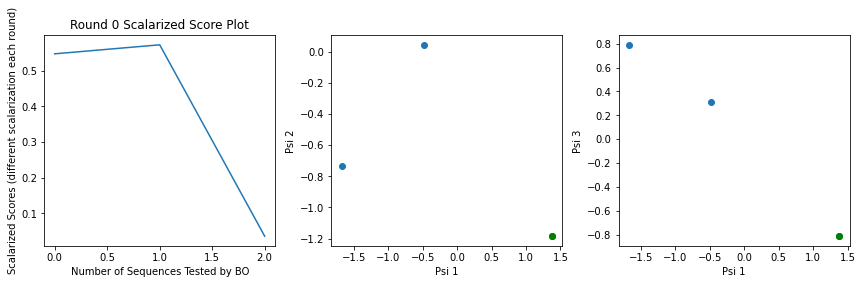

Round  0  mean score:  0.38525072086893
Random Scalarization (Lambda):  [0.19556284 0.01246139 0.03335415 0.75862162]
[ 1.40227494 -1.20473577 -0.80068658] -suggested new point
Peak Memory Used This Round:  250610692
2.8888721466064453
ETA:  86  seconds
------------------------------------------------------------------------



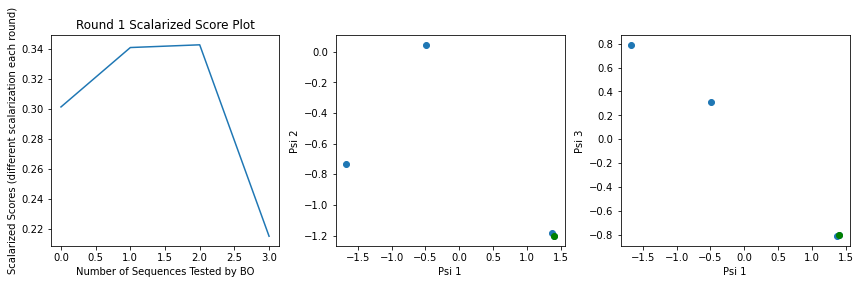

Round  1  mean score:  0.3000253604500811
Random Scalarization (Lambda):  [0.14031769 0.27298955 0.25601502 0.33067774]
[ 0.6712641  -0.65874729 -1.14209041] -suggested new point
Peak Memory Used This Round:  155311288
2.8326565186182657
ETA:  84  seconds
------------------------------------------------------------------------



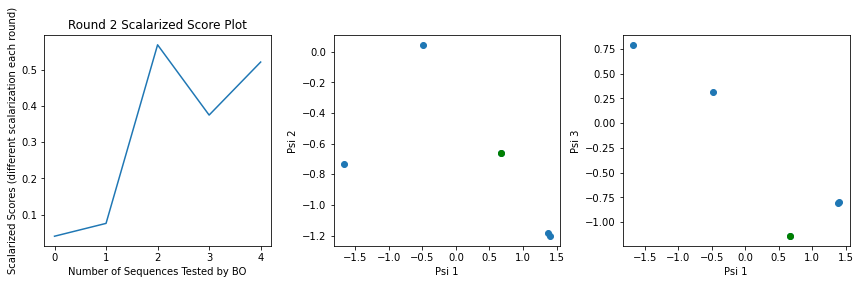

Round  2  mean score:  0.3159832795069616
Random Scalarization (Lambda):  [0.26174576 0.38550019 0.27528459 0.07746946]
[ 0.97669778 -0.87147213 -0.72200114] -suggested new point
Peak Memory Used This Round:  187204539
2.7969753795199925
ETA:  83  seconds
------------------------------------------------------------------------



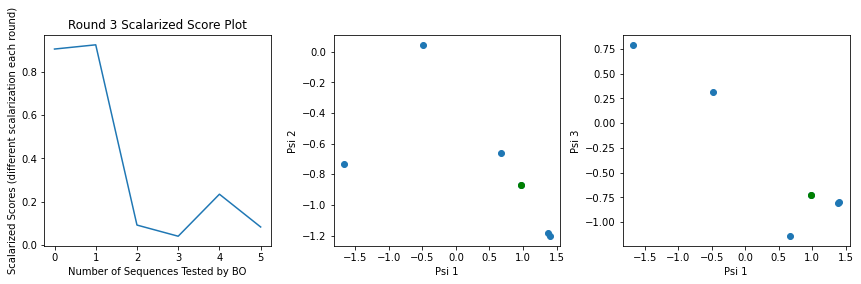

Round  3  mean score:  0.38034064621435176
Random Scalarization (Lambda):  [0.10273169 0.07275931 0.19486589 0.62964311]
[-0.80220701 -0.03220327  0.49217533] -suggested new point
Peak Memory Used This Round:  219232484
2.5998708844184875
ETA:  77  seconds
------------------------------------------------------------------------



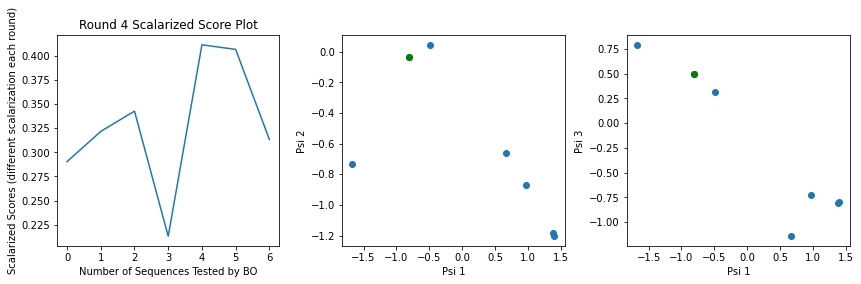

Round  4  mean score:  0.3285113306257858
Random Scalarization (Lambda):  [0.15470942 0.27804796 0.28547758 0.28176504]
[ 1.23138796 -1.16537246 -1.73938038] -suggested new point
Peak Memory Used This Round:  251316510
2.500863536198934
ETA:  75  seconds
------------------------------------------------------------------------



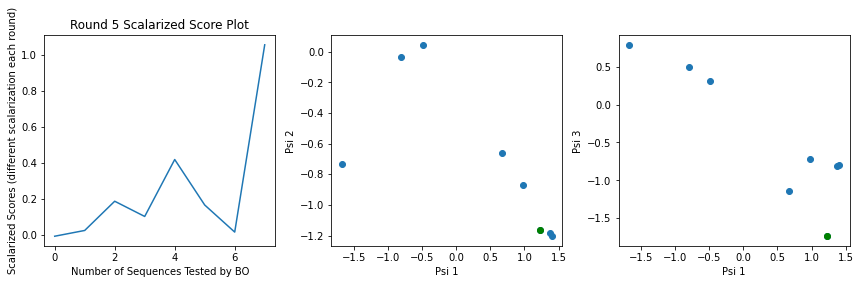

Round  5  mean score:  0.24420785552945176
Random Scalarization (Lambda):  [0.15534207 0.14399854 0.30320379 0.39745561]
[ 1.14988649 -0.96277052 -1.41199303] -suggested new point
Peak Memory Used This Round:  283141155
2.448813484774696
ETA:  73  seconds
------------------------------------------------------------------------



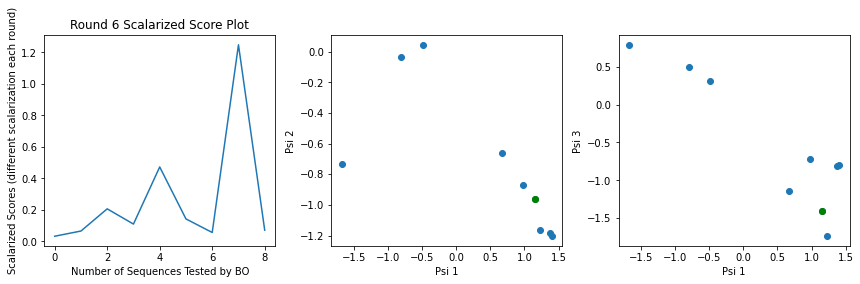

Round  6  mean score:  0.26791450988682186
Random Scalarization (Lambda):  [0.10868558 0.11254337 0.33434822 0.44442284]
[ 0.69298979 -1.89221667 -1.47000021] -suggested new point
Peak Memory Used This Round:  315190114
2.401950209481376
ETA:  72  seconds
------------------------------------------------------------------------



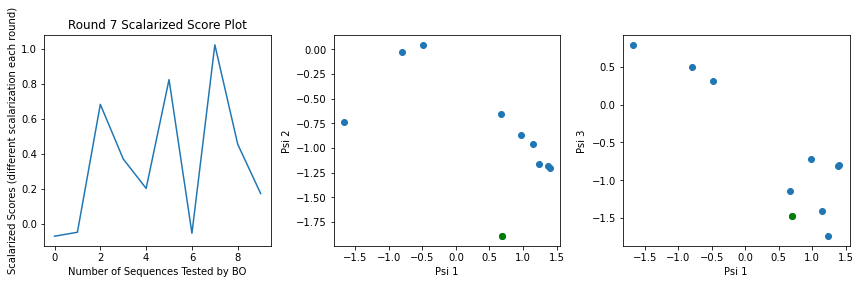

Round  7  mean score:  0.3553042427340275
Random Scalarization (Lambda):  [0.06915371 0.68393436 0.14840699 0.09850494]
[-0.56039719 -0.01465483 -1.28213077] -suggested new point
Peak Memory Used This Round:  347191512
2.3904980838298795
ETA:  71  seconds
------------------------------------------------------------------------



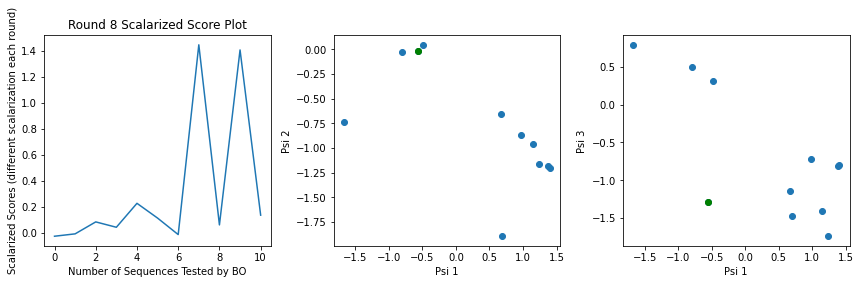

Round  8  mean score:  0.3169603529779778
Random Scalarization (Lambda):  [0.14486671 0.03478595 0.14774095 0.67260638]
[ 1.2633432 -1.7531114 -2.4975702] -suggested new point
Peak Memory Used This Round:  379246347
2.319818867577447
ETA:  69  seconds
------------------------------------------------------------------------



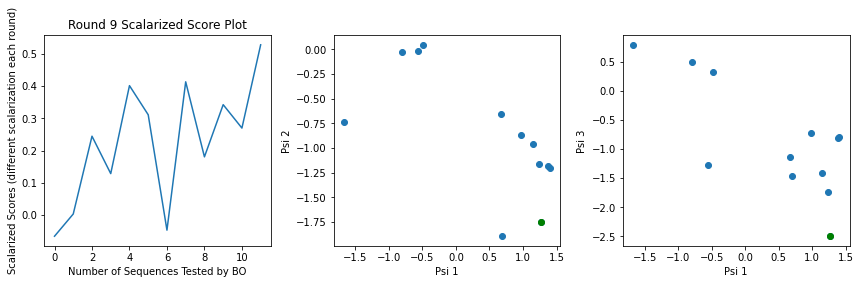

Round  9  mean score:  0.22590679469579977
Random Scalarization (Lambda):  [0.27159999 0.30723186 0.22913891 0.19202924]
[ 0.81215063 -1.39224318 -1.09853561] -suggested new point
Peak Memory Used This Round:  411255261
2.2125717854499816
ETA:  66  seconds
------------------------------------------------------------------------



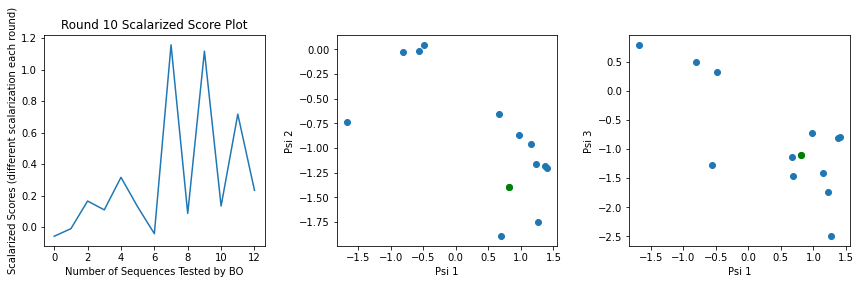

Round  10  mean score:  0.31212353268962684
Random Scalarization (Lambda):  [0.09612081 0.09321455 0.25700666 0.55365799]
[ 1.69705799 -1.62732855 -1.97415485] -suggested new point
Peak Memory Used This Round:  443297905
2.103063930164684
ETA:  63  seconds
------------------------------------------------------------------------



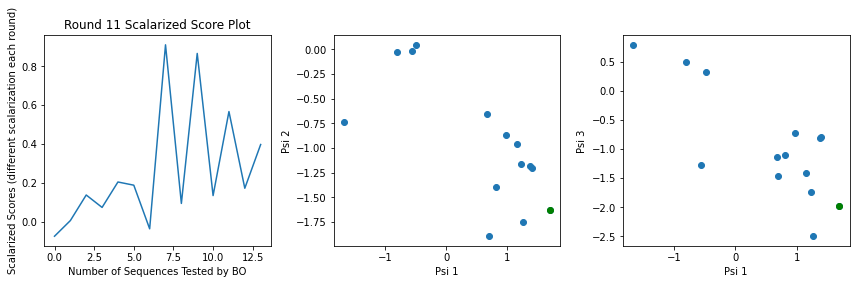

Round  11  mean score:  0.2600725248089065
Random Scalarization (Lambda):  [0.15949661 0.26056543 0.14898837 0.43094959]
[ 0.67139514 -1.28716573 -2.33771925] -suggested new point
Peak Memory Used This Round:  475065923
1.9908813012970816
ETA:  59  seconds
------------------------------------------------------------------------



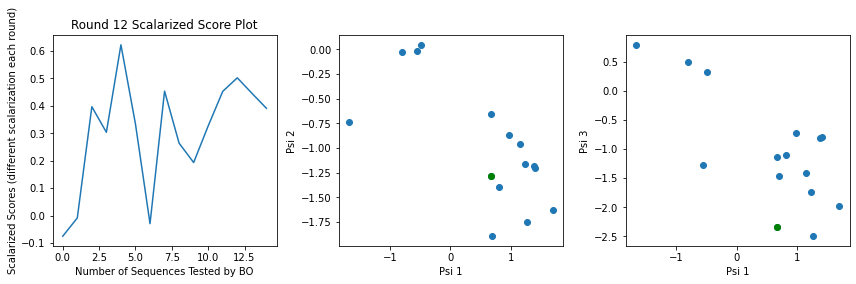

Round  12  mean score:  0.30494799335129413
Random Scalarization (Lambda):  [0.05979339 0.31642327 0.46806308 0.15572026]
[ 0.10538391  0.04052215 -1.14130904] -suggested new point
Peak Memory Used This Round:  507124383
1.9033721813788782
ETA:  57  seconds
------------------------------------------------------------------------



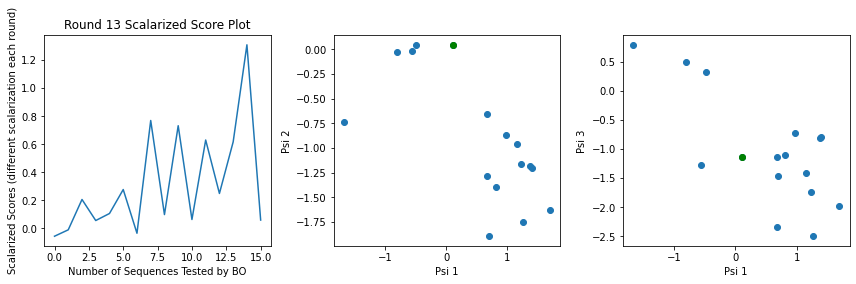

Round  13  mean score:  0.317182391241156
Random Scalarization (Lambda):  [0.10065058 0.37865794 0.01900464 0.50168684]
[ 1.09132684 -1.66467245 -1.91801941] -suggested new point
Peak Memory Used This Round:  539130852
1.8151705219632104
ETA:  54  seconds
------------------------------------------------------------------------



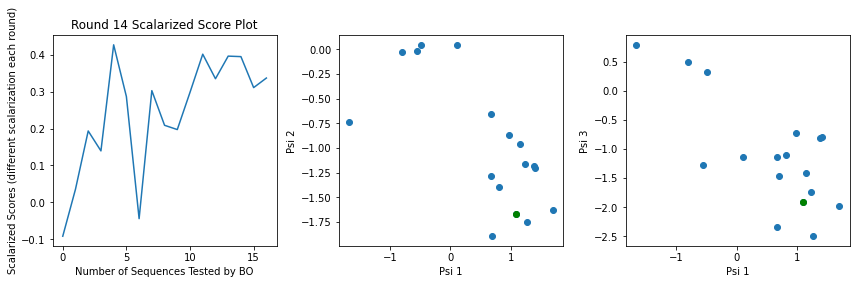

Round  14  mean score:  0.24280705124891752
Random Scalarization (Lambda):  [0.3044293  0.27283971 0.24230716 0.18042383]
[-0.1948199  -0.67030682 -1.42406647] -suggested new point
Peak Memory Used This Round:  571040493
1.7167394765218098
ETA:  51  seconds
------------------------------------------------------------------------



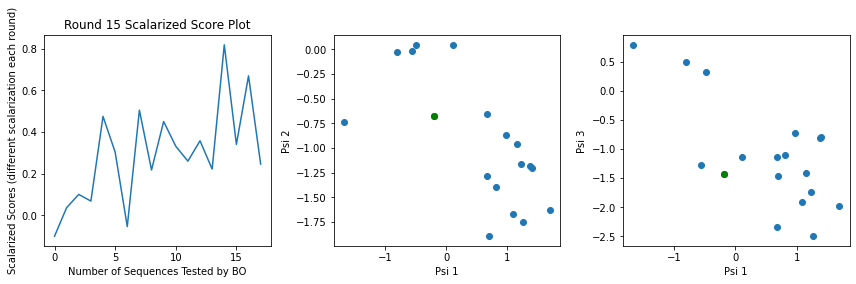

Round  15  mean score:  0.2916891856798507
Random Scalarization (Lambda):  [0.35028042 0.15547903 0.13479259 0.35944796]
[ 1.13759145 -1.1374302  -2.51645697] -suggested new point
Peak Memory Used This Round:  603025637
1.6124327331781387
ETA:  48  seconds
------------------------------------------------------------------------



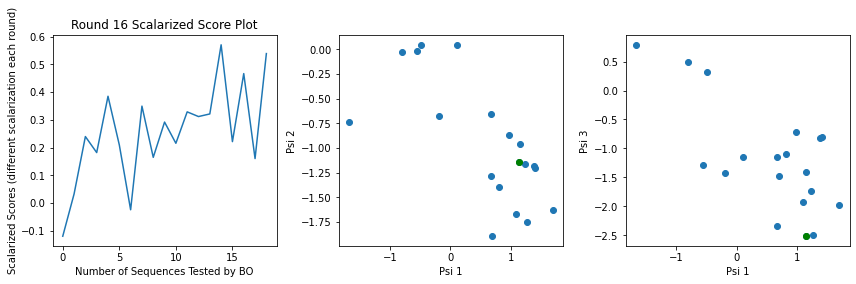

Round  16  mean score:  0.2552748776109189
Random Scalarization (Lambda):  [0.2187623  0.20722894 0.28622198 0.28778679]
[-0.02335541 -2.67977912 -1.72083109] -suggested new point
Peak Memory Used This Round:  635086813
1.517541565614588
ETA:  45  seconds
------------------------------------------------------------------------



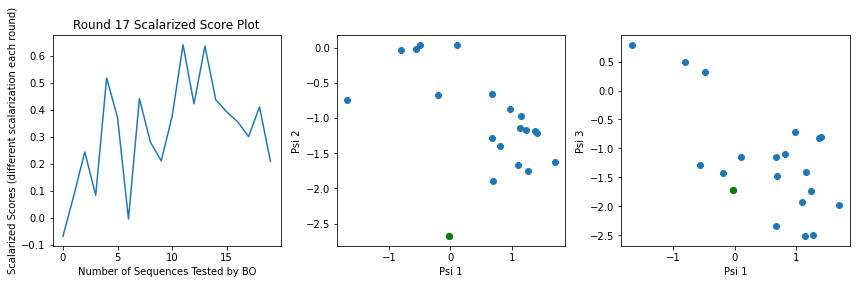

Round  17  mean score:  0.3180237577339919
Random Scalarization (Lambda):  [0.373819   0.37092885 0.02920417 0.22604798]
[ 1.64394694 -1.44008724 -2.35813808] -suggested new point
Peak Memory Used This Round:  667036645
1.4198126603055885
ETA:  42  seconds
------------------------------------------------------------------------



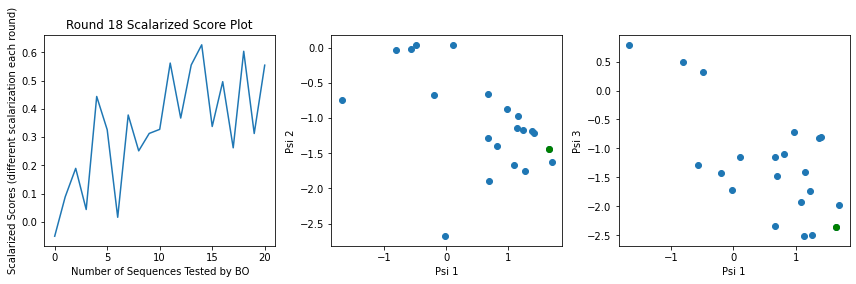

Round  18  mean score:  0.3337956839602184
Random Scalarization (Lambda):  [0.31914204 0.35120739 0.01633873 0.31331184]
[ 0.72421391 -1.41481983 -2.81760018] -suggested new point
Peak Memory Used This Round:  699042954
1.3170602396914834
ETA:  39  seconds
------------------------------------------------------------------------



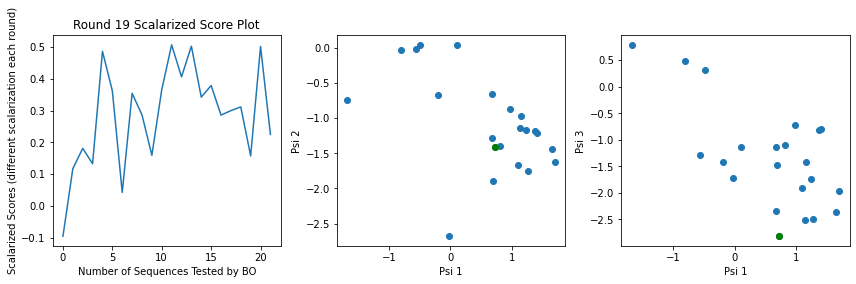

Round  19  mean score:  0.2871491413107542
Random Scalarization (Lambda):  [0.33055318 0.33051665 0.16521384 0.17371634]
[ 0.20417986 -0.44894937 -1.18390193] -suggested new point
Peak Memory Used This Round:  731038816
1.2109910078843436
ETA:  36  seconds
------------------------------------------------------------------------



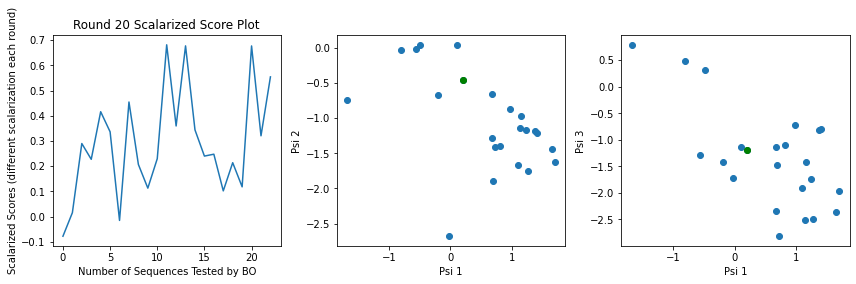

Round  20  mean score:  0.29260934639871145
Random Scalarization (Lambda):  [0.12503461 0.42421541 0.32441769 0.12633229]
[ 0.26970613 -2.7511264  -0.88432732] -suggested new point
Peak Memory Used This Round:  763079344
1.0988710872710699
ETA:  32  seconds
------------------------------------------------------------------------



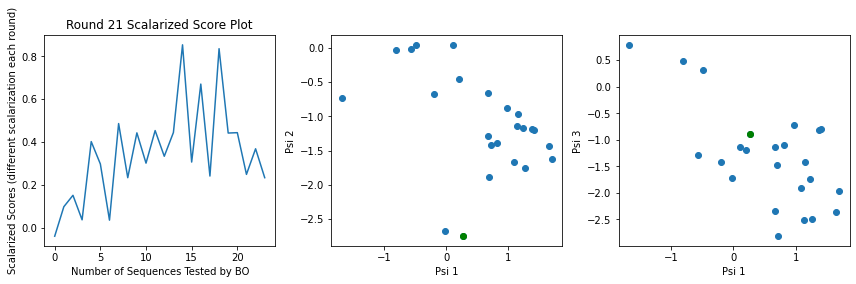

Round  21  mean score:  0.34640380146420174
Random Scalarization (Lambda):  [0.29529075 0.26751389 0.01251843 0.42467693]
[-0.3788174   0.80274243  0.3374266 ] -suggested new point
Peak Memory Used This Round:  795003932
0.9885115970264784
ETA:  29  seconds
------------------------------------------------------------------------



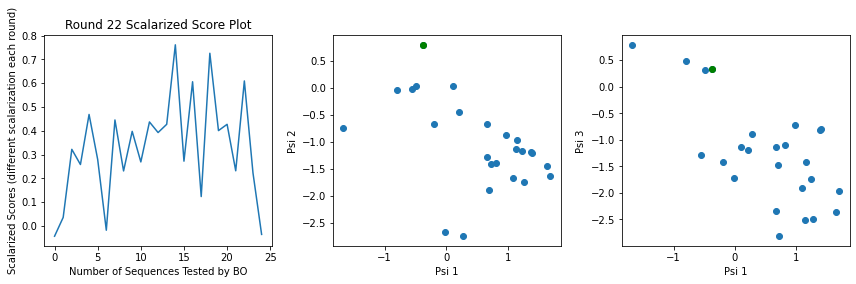

Round  22  mean score:  0.32987306015200746
Random Scalarization (Lambda):  [0.02893509 0.25618774 0.34581406 0.36906311]
[ 0.76894418 -1.0599915  -2.38970067] -suggested new point
Peak Memory Used This Round:  827122661
0.8811723432679109
ETA:  26  seconds
------------------------------------------------------------------------



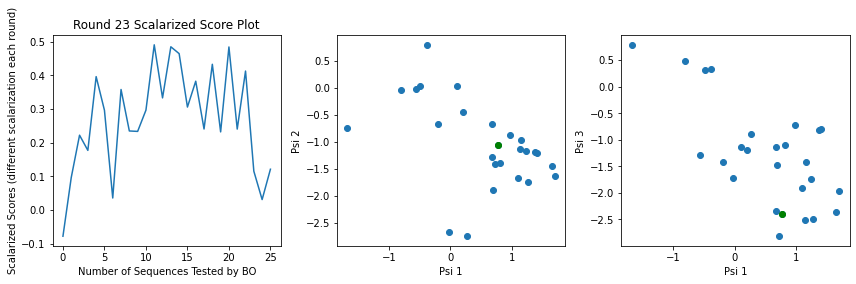

Round  23  mean score:  0.2708055241677378
Random Scalarization (Lambda):  [0.26472264 0.2853324  0.22118782 0.22875714]
[-0.03961096 -1.72258663 -1.88760132] -suggested new point
Peak Memory Used This Round:  859088011
0.7717318769958282
ETA:  23  seconds
------------------------------------------------------------------------



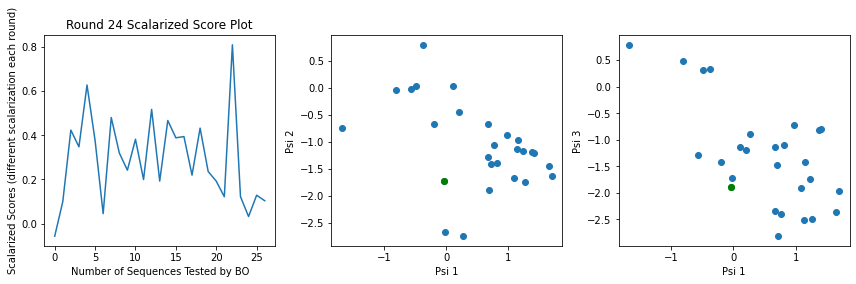

Round  24  mean score:  0.29059432427228254
Random Scalarization (Lambda):  [0.22247547 0.13381328 0.41546391 0.22824735]
[-1.51544464  0.30243172 -1.11958205] -suggested new point
Peak Memory Used This Round:  891040996
0.6606441917419432
ETA:  19  seconds
------------------------------------------------------------------------



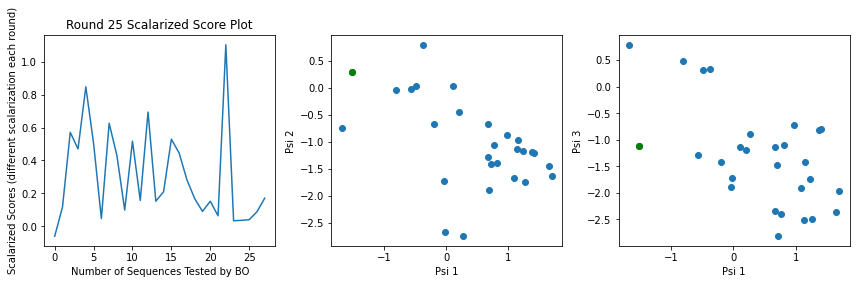

Round  25  mean score:  0.30663043888008357
Random Scalarization (Lambda):  [0.22013125 0.11604544 0.55327591 0.1105474 ]
[ 1.06304582 -1.20913926 -1.1403583 ] -suggested new point
Peak Memory Used This Round:  923068061
0.5524781804818372
ETA:  16  seconds
------------------------------------------------------------------------



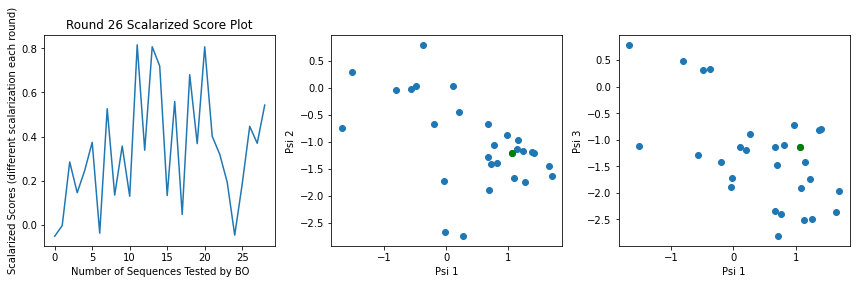

Round  26  mean score:  0.33765222537314765
Random Scalarization (Lambda):  [0.0067657  0.46326733 0.18774422 0.34222275]
[ 0.10993024 -2.17992671 -1.28259269] -suggested new point
Peak Memory Used This Round:  955042262
0.4422095911002452
ETA:  13  seconds
------------------------------------------------------------------------



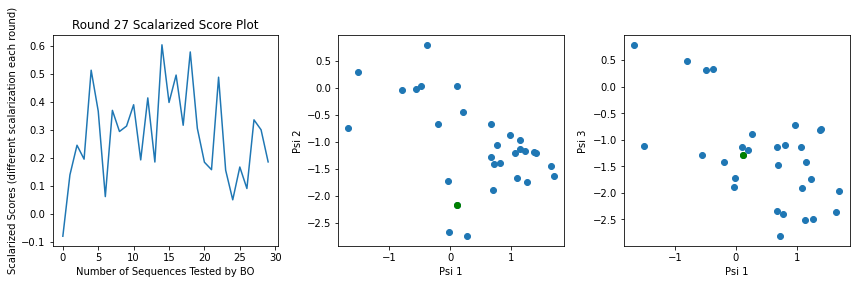

Round  27  mean score:  0.2817200786275667
Random Scalarization (Lambda):  [0.32361078 0.12590531 0.25375191 0.29673199]
[ 1.94860672 -0.31572407 -0.7959441 ] -suggested new point
Peak Memory Used This Round:  987130790
0.3319520950317382
ETA:  9  seconds
------------------------------------------------------------------------



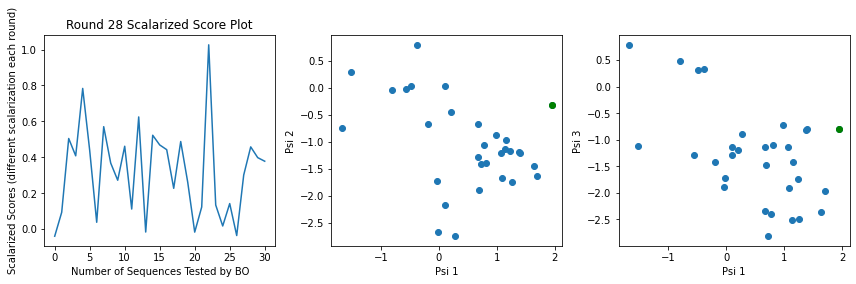

Round  28  mean score:  0.3215673632287836
Random Scalarization (Lambda):  [0.20859063 0.00635628 0.52968662 0.25536647]
[ 1.59979313 -0.75760535 -0.80357509] -suggested new point
Peak Memory Used This Round:  1019125148
0.22152790749210047
ETA:  6  seconds
------------------------------------------------------------------------



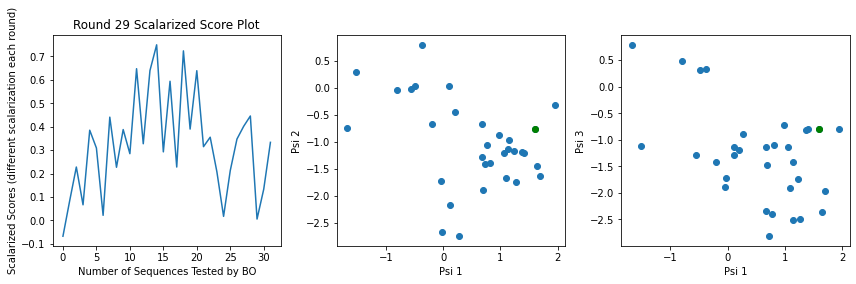

Round  29  mean score:  0.32409478060097713
Random Scalarization (Lambda):  [0.26229737 0.36111637 0.03297756 0.3436087 ]
[ 0.3691382  -2.20541153 -2.22400753] -suggested new point
Peak Memory Used This Round:  1051188674
0.11086167414983111
ETA:  3  seconds
------------------------------------------------------------------------



In [84]:
num_rounds = 30
bayesian_optimizer.sequences = initial_sequences
bayesian_optimizer.run_BO(num_rounds)

# Plotting and Analysis #
The *ploting.ipynb* has some example code to do preliminary analysis. The scores of each round are saved in the data folder. 

VAE, DCA, and functionality are reported as costs, so to retrieve the probabilites, one must multiply these columns by negative one

In [85]:
bayesian_optimizer.observed_y

array([[ 8.14413463e-01,  2.78807925e+02, -1.31358534e+02,
        -9.19354839e-01],
       [ 1.08417632e+00,  5.44629581e+02, -1.13053135e+02,
        -9.19354839e-01],
       [ 1.02269627e+00,  3.57012690e+03, -9.83673089e+01,
        -9.35483871e-01],
       [ 9.68198841e-01,  2.96200290e+03, -1.01560867e+02,
        -9.35483871e-01],
       [ 1.55855314e+00,  1.31825117e+03, -8.94041417e+01,
        -9.35483871e-01],
       [ 1.36256634e+00,  3.84229582e+03, -1.00883464e+02,
        -9.35483871e-01],
       [ 9.86759457e-01,  5.76752229e+02, -1.18059874e+02,
        -9.19354839e-01],
       [ 1.32360378e+00,  4.20433974e+03, -9.72028392e+01,
        -8.70967742e-01],
       [ 1.27330199e+00,  3.12024877e+03, -1.03160103e+02,
        -9.35483871e-01],
       [ 6.07934119e-01,  1.88612630e+03, -1.27135008e+02,
        -8.70967742e-01],
       [ 1.40834667e+00,  9.40389427e+02, -1.00103995e+02,
        -9.35483871e-01],
       [ 2.50429783e-01,  5.18299498e+03, -1.46102763e+02,
      

In [95]:
#for human readable probabilites/costs
def revert_scores(s):
    s[0] = -1*s[0]
    s[2] = -1*s[2]
    s[3] = -1*s[3]
    return s

In [96]:
#how scoring is performed
scores, sequence = multi_dimensional_cost([0.5,0.5,0.5])
scores = revert_scores(scores)
print("VAE: %8.2f    Pyrosetta: %8.2f DCA: %8.2f Functionality: %8.2f Sequence: %s" % tuple(scores))

VAE:    -1.20    Pyrosetta:   633.40 DCA:   119.01 Functionality:     0.94
